Bu notebook'un amacı, Büyük Dil Modelleri (LLM) değerlendirmesinde sıkça kullanılan dört temel metriği anlamak ve uygulamaktır:

    Perplexity: Dil modelinin kalitesini ölçmek için.
    BLEU: Makine çevirisi kalitesini ölçmek için.
    ROUGE: Otomatik özetleme kalitesini ölçmek için.
    METEOR: BLEU ve ROUGE'un eksiklerini gidermeye çalışan daha gelişmiş bir metrik.

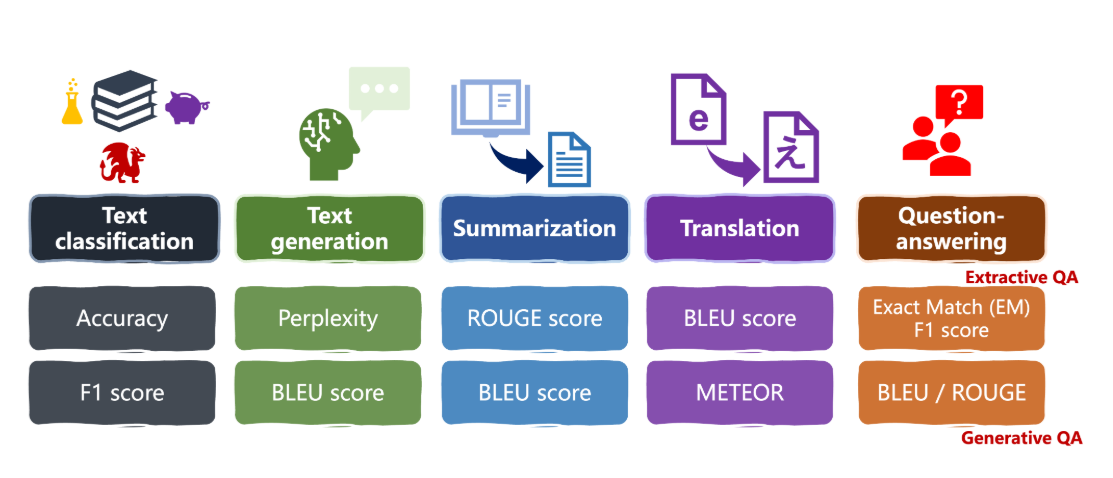

In [ ]:
! pip install evaluate transformers torch nltk

In [ ]:
# Kütüphaneleri içeri aktaralım
import torch
import evaluate
import nltk

# METEOR metriği için nltk'nın 'wordnet' paketini indirmemiz gerekebilir / bu teknik kelimenin ek ve kök yapılarına karsı duyarlıdır

print("NLTK 'wordnet' ve 'punkt' paketleri indiriliyor/doğrulanıyor...")
nltk.download('wordnet')
nltk.download('punkt')
print("İşlem tamamlandı. Paketler kullanıma hazır.")

NLTK 'wordnet' ve 'punkt' paketleri indiriliyor/doğrulanıyor...


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


İşlem tamamlandı. Paketler kullanıma hazır.


**1. Perplexity**

* Düşük Perplexity : Modelin metni tahmin etmekte zorlanmadığını, yani metnin olasılığını yüksek gördüğünü belirtir. 
* Yüksek Perplexity: Modelin metni tahmin ederken çok "şaşırdığını", yani metnin olasılığını düşük gördüğünü belirtir. 
    * Avantajları ve Dezavantajları
        - Avantajı: Referans bir metne ihtiyaç duymaz. Sadece bir model ve bir test metni ile hesaplanabilir. Modelin kendi iç tutarlılığını ölçer.
        - Dezavantajı: Farklı kelime dağarcığına (vocabulary) sahip modeller arasında doğrudan bir karşılaştırma aracı değildir. 
        Her zaman insan yargısıyla doğrudan ilişkili olmayabilir.

In [7]:
# Değerlendirilecek metin
data = ["Ankara, Türkiye'nin başkentidir."]

# Modeli belirtiyoruz (örnek olarak küçük bir model)
model_id = "gpt2"

# Metriği hesaplıyoruz
perplexity_metric = evaluate.load("perplexity", module_type="metric")
perplexity_metric.add_batch(predictions=data)
results = perplexity_metric.compute(model_id=model_id,
                                    add_start_token=False# GPT-2 gibi modeller için false
                                    )

print(f"Perplexity Skoru: {results['mean_perplexity']:.2f}")

# Daha anlamsız bir cümle ile deneyelim
anlamsiz_veri = ["Ankara uçan masmavi bir fil yedi."]
perplexity_metric_2 = evaluate.load("perplexity", module_type="metric")
perplexity_metric_2.add_batch(predictions=anlamsiz_veri)
results_anlamsiz = perplexity_metric_2.compute(model_id=model_id,
                                             add_start_token=False
                                             )

print(f"Anlamsız Cümle için Perplexity: {results_anlamsiz['mean_perplexity']:.2f} (Daha yüksek, yani daha kötü)")

100%|██████████| 1/1 [00:00<00:00,  7.60it/s]


Perplexity Skoru: 121.15


100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

Anlamsız Cümle için Perplexity: 1191.27 (Daha yüksek, yani daha kötü)


**2. BLEU (Bilingual Evaluation Understudy)**

* Nedir?
    - BLEU, makine tarafından üretilen bir metnin (aday metin), bir veya daha fazla insan tarafından üretilmiş referans metne ne kadar benzediğini ölçer. Genellikle makine çevirisi görevlerinde kullanılır.

* Nasıl Çalışır?
    - Temelde n-gram hassasiyetine (precision) dayanır. Aday metindeki n-gram'ların (1-gram, 2-gram, ..., 4-gram) referans metinlerde ne sıklıkla geçtiğini sayar. 
    - Çok kısa metinleri cezalandırmak için bir "kısalık cezası" (brevity penalty) uygular.

* Avantajları ve Dezavantajları
    - Avantajı: Hızlı ve kolay hesaplanır. İnsan çevirmenlerin yargılarıyla yüksek oranda uyumlu olduğu gösterilmiştir.
    - Dezavantajı: Anlamı veya eş anlamlı kelimeleri dikkate almaz ("hızlı" ve "çabuk" kelimelerini farklı sayar). Cümlenin dilbilgisel doğruluğunu ölçmez.

In [ ]:
!  pip install sacrebleu

In [ ]:
# Not: Neden 'bleu' yerine 'sacrebleu' kullanıyoruz?
#
# Sacrebleu, farklı bir metrik değildir; BLEU'nun standartlaştırılmış versiyonudur.
# Temel avantajları şunlardır:
# 1. Standart Tokenizasyon: Herkesin aynı tokenizasyon yöntemini kullanmasını sağlayarak
#    sonuçların adil ve tekrarlanabilir olmasını garantiler.
# 2. Otomatik Smoothing (Düzeltme): Kısa cümlelerde veya az n-gram eşleşmesi olan
#    durumlarda skorun anlamsız bir şekilde 0.0'a düşmesini engeller.
#
# Bu nedenlerle, modelleri karşılaştırırken veya akademik çalışmalarda her zaman
# 'sacrebleu' tercih edilir.

In [7]:
# Gerekli kütüphaneleri yüklediğimizden emin olalım
# !pip install evaluate sacrebleu

import evaluate

# 1. Metriği Yükleme
# 'bleu' yerine daha sağlam olan ve smoothing'i otomatik yapan 'sacrebleu' kullanıyoruz.
sacrebleu_metric = evaluate.load("sacrebleu")


# 2. Referans ve Aday Cümleleri Hazırlama
# Referanslar (insan çevirileri - olabilecek en iyi sonuçlar)
list_of_references = [
    "Güneşli bir günde çocuklar parkta neşeyle oynuyordu",
    "Çocuklar parkta güneşli bir günde keyifle oynuyordu"
]

# Adaylar (modelin ürettiği varsayılan farklı kalitedeki çeviriler)
candidates = [
    "Güneşli bir günde çocuklar parkta neşeyle oynuyordu",        # 1. Mükemmel Eşleşme
    "Çocuklar güneşli bir günde parkta neşeyle oynuyordu",        # 2. İyi (Sıra değişik)
    "Güneşli bir günde çocuklar parkta mutlulukla oynuyordu",     # 3. Orta (Eş anlamlı kelime)
    "Çocuklar parkta oynuyordu",                                  # 4. Zayıf (Eksik bilgi)
    "Kedi masanın altında uyuyordu"                               # 5. Alakasız
]


# 3. Skorları Hesaplama ve Yazdırma
print("--- Sacrebleu Skorlarının Kademeli Analizi ---\n")

for i, candidate in enumerate(candidates):
    # compute fonksiyonunu doğru veri yapısıyla çağırıyoruz
    results = sacrebleu_metric.compute(
        predictions=[candidate],                  # Aday, tek elemanlı bir liste içinde
        references=[list_of_references]           # Referans listesi, tek elemanlı bir dış liste içinde
    )
    
    # Sonucu 'score' anahtarından alıp yazdırıyoruz (skor 0-100 arasındadır)
    print(f"Aday {i+1}: '{candidate}'")
    print(f"Sacrebleu Skoru: {results['score']:.2f}\n" + "-"*40)

--- Sacrebleu Skorlarının Kademeli Analizi ---

Aday 1: 'Güneşli bir günde çocuklar parkta neşeyle oynuyordu'
Sacrebleu Skoru: 100.00
----------------------------------------
Aday 2: 'Çocuklar güneşli bir günde parkta neşeyle oynuyordu'
Sacrebleu Skoru: 42.73
----------------------------------------
Aday 3: 'Güneşli bir günde çocuklar parkta mutlulukla oynuyordu'
Sacrebleu Skoru: 64.35
----------------------------------------
Aday 4: 'Çocuklar parkta oynuyordu'
Sacrebleu Skoru: 0.00
----------------------------------------
Aday 5: 'Kedi masanın altında uyuyordu'
Sacrebleu Skoru: 0.00
----------------------------------------


**3. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)**

* **Nedir?**
    ROUGE, genellikle otomatik metin özetleme görevlerinde kullanılır. 
    BLEU'nun aksine, geri çağırmaya (recall) odaklanır. 
    Yani, referans özetteki kelimelerin/cümlelerin ne kadarının model tarafından üretilen özette yer aldığını ölçer.

* **Nasıl Çalışır?**
    Farklı ROUGE türleri vardır:

- **ROUGE-N**: BLEU gibi n-gram örtüşmesini ölçer (örn: ROUGE-1, ROUGE-2).
- **ROUGE-L**: En uzun ortak alt diziyi (Longest Common Subsequence - LCS) kullanır. Bu, kelimelerin sırasını dikkate alır ve daha akıcı özetleri ödüllendirir.
* Avantajları ve Dezavantajları
- Avantajı: Özetin referanstaki önemli bilgileri ne kadar kapsadığını ölçmek için idealdir. ROUGE-L, cümle yapısını bir miktar dikkate alır.
- Dezavantajı: BLEU gibi, anlamı veya yeniden ifade etmeyi (paraphrasing) anlamaz.

In [ ]:
# ROUGE metriği için gerekli olan ek paketleri yüklüyoruz.
! pip install rouge-score absl-py

In [ ]:
import evaluate

# ROUGE metriğini yüklüyoruz.
rouge_metric = evaluate.load('rouge')

# Model tarafından üretilen özet (aday)
candidate_summary = "iklim değişikliği gezegeni tehdit ediyor"

# Referans özetler (insanların yazdığı)
reference_summaries = [
    "iklim değişikliği gezegenimiz için büyük bir tehdit oluşturuyor",
    "gezegendeki yaşam iklim değişikliği tehdidi altında"
]

# DÜZELTME: 'reference_summaries' listesini bir dış liste içine alıyoruz.
# Bu, "bir aday için bir referans listesi" yapısını oluşturur.
results = rouge_metric.compute(
    predictions=[candidate_summary],
    references=[reference_summaries]  # <<<--- KRİTİK DÜZELTME BURADA
)

print("ROUGE Skorları:")
print(results)

ROUGE Skorları:
{'rouge1': np.float64(0.5263157894736842), 'rouge2': np.float64(0.47058823529411764), 'rougeL': np.float64(0.5263157894736842), 'rougeLsum': np.float64(0.5263157894736842)}


**4. METEOR (Metric for Evaluation of Translation with Explicit ORdering)**
**Nedir?**
- METEOR, BLEU'nun eksikliklerini gidermek için tasarlanmış daha gelişmiş bir metriktir. Sadece tam n-gram eşleşmelerine bakmak yerine, eş anlamlıları ve kökleri (stemming) de dikkate alır.

**Nasıl Çalışır?**
Aday ve referans metinleri kelime kelime eşleştirir.
Sadece tam eşleşmeleri değil, WordNet gibi bir veritabanı kullanarak eş anlamlıları ve aynı kökten gelen kelimeleri de eşleşme olarak sayar.
Eşleşmelerin ne kadar "gruplu" ve "doğru sırada" olduğuna bakarak bir ceza puanı uygular.
**Avantajları ve Dezavantajları**
- Avantajı: Anlamsal benzerliğe daha duyarlıdır. İnsan yargılarıyla BLEU'dan daha iyi bir korelasyona sahip olduğu bilinmektedir.
- Dezavantajı: BLEU ve ROUGE'a göre hesaplaması daha yavaş ve karmaşıktır. WordNet gibi harici dil kaynaklarına bağımlıdır.

In [38]:
import evaluate

# METEOR metriğini yüklüyoruz.
meteor_metric = evaluate.load('meteor')

# Aday çeviri (modelin ürettiği)
candidate = "uçak çabucak indi"


# Tek bir aday için tüm referanslar aynı listenin içinde olmalı.
reference_list = [
    "uçak çabucak indi",
    "hava aracı piste süratle indi"
]

# compute fonksiyonuna verirken doğru yapıyı kullanıyoruz:
# predictions: ['...']
# references: [['...', '...']]
results = meteor_metric.compute(
    predictions=[candidate],
    references=[reference_list]   
)

print(f"METEOR Skoru: {results['meteor']:.4f}")

METEOR Skoru: 0.9815


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [40]:
import evaluate

# METEOR metriğini yüklüyoruz.
meteor_metric = evaluate.load('meteor')

# --- Referans Cümlelerimizi Tanımlayalım ---
# Referans 2'de bolca eş anlamlı kelime kullandığımıza dikkat edin.
list_of_references = [
    "Hızlı kahverengi tilki tembel köpeğin üzerinden atladı",
    "Çevik kahverengi tilki uyuşuk bir köpeğin üstünden sıçradı"
]

# --- METEOR'un Özelliklerini Test Edecek Aday Cümleler ---
candidates = [
    # 1. Mükemmel Eşleşme: Referansla birebir aynı.
    "Hızlı kahverengi tilki tembel köpeğin üzerinden atladı",

    # 2. Eş Anlamlı Testi: BLEU'nun sıfıra yakın skor vereceği ama METEOR'un yakalaması gereken durum.
    "Çevik kahverengi tilki uyuşuk köpeğin üstünden atladı",
    
    # 3. Kelime Kökü (Stemming) Testi: Farklı ekler almış kelimeler.
    "Hızlı kahverengi tilkiler tembel köpeklerin üzerinden atlıyor",

    # 4. Akıcılık (Chunk Penalty) Testi: Kelimeler doğru ama sıra bozuk.
    "Tembel köpeğin üzerinden atladı hızlı kahverengi tilki",

    # 5. Fazlalık Kelime (Penalty) Testi: Gereksiz kelimeler içeren cümle.
    "Hızlı olan kahverengi tilki bir şekilde tembel köpeğin üzerinden atladı",

    # 6. Eksik Bilgi Testi: Önemli sıfatlar eksik.
    "Kahverengi tilki köpeğin üzerinden atladı"
]

print("--- METEOR Skorlarının Odaklı Analizi ---\n")

# Her bir adayı döngüye alıp skorunu hesaplayalım
for i, candidate in enumerate(candidates):
    results = meteor_metric.compute(
        predictions=[candidate],
        references=[list_of_references]
    )
    print(f"Aday {i+1}: '{candidate}'")
    print(f"METEOR Skoru: {results['meteor']:.4f}\n" + "-"*50)

--- METEOR Skorlarının Odaklı Analizi ---

Aday 1: 'Hızlı kahverengi tilki tembel köpeğin üzerinden atladı'
METEOR Skoru: 0.9985
--------------------------------------------------
Aday 2: 'Çevik kahverengi tilki uyuşuk köpeğin üstünden atladı'
METEOR Skoru: 0.7454
--------------------------------------------------
Aday 3: 'Hızlı kahverengi tilkiler tembel köpeklerin üzerinden atlıyor'
METEOR Skoru: 0.4509
--------------------------------------------------
Aday 4: 'Tembel köpeğin üzerinden atladı hızlı kahverengi tilki'
METEOR Skoru: 0.9883
--------------------------------------------------
Aday 5: 'Hızlı olan kahverengi tilki bir şekilde tembel köpeğin üzerinden atladı'
METEOR Skoru: 0.9212
--------------------------------------------------
Aday 6: 'Kahverengi tilki köpeğin üzerinden atladı'
METEOR Skoru: 0.7118
--------------------------------------------------


[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


- burada çıktılar beklediğim gibi olmadı. Aday 4 cümlesinin sıra bozukluğu nedeniyle akıcılık açısından ceza almasını
- (penalty) bu sebeple daha füşük olmasını bekledim.

**
- METEOR, bu büyük ve kendi içinde tutarlı blokların yer değiştirmesini, küçük ve tekil kelimelerin dağınık olmasından çok daha az cezalandırır. Cümlenin tüm kelimeleri %100 doğru olduğu için (precision=1.0, recall=1.0), ve ceza çok düşük olduğu için, nihai skor 1.0'a çok yakın çıkmıştır.
- Çıkarım: METEOR, basit kelime sırası bozukluğundan çok, eşleşen kelimelerin ne kadar parçalandığına odaklanır.
**

In [ ]:
! pip install bert-score

In [ ]:
import evaluate

# BERTScore metriğini yüklüyoruz.
bertscore_metric = evaluate.load("bertscore")

# --- Referans Cümlemizi Tanımlayalım ---
reference = "Hasta, doktorun tavsiyesine uyarak ilaçlarını düzenli olarak aldı."

# --- Aday Cümlelerimizi Tanımlayalım ---
candidates = [
    # 1. İyi Aday (Anlamı Koruyan Yeniden İfade Etme)
    # BLEU bu cümleye düşük puan verir, çünkü kelimeler farklı.
    "Hasta, hekimin önerisini dinleyip ilaçlarını aksatmadan kullandı.",

    # 2. Kötü Aday (Aynı Kelimeler, Yanlış Anlam)
    # BLEU bu cümleye yüksek puan verir, çünkü kelimeler aynı.
    "Doktor, hastanın ilacını alarak tavsiyesine düzenli olarak uydu."
]

# Skorları hesaplıyoruz. Türkçe için 'lang="tr"' parametresi 
results = bertscore_metric.compute(
    predictions=candidates,
    references=[reference, reference], # Her aday için aynı referansı kullanıyoruz
    lang="tr" # Türkçe BERT modeli kullanılmasını sağlar
)

# Sonuçları daha anlaşılır bir formatta yazdıralım
# BERTScore; precision, recall ve f1 skoru döndürür. Genellikle f1'e bakılır.
print("--- BERTScore Analizi ---\n")

print(f"Referans Cümle: '{reference}'\n" + "-"*50)

print(f"İyi Aday (Anlamı Koruyan): '{candidates[0]}'")
print(f"F1 Skoru: {results['f1'][0]:.4f}\n")

print(f"Kötü Aday (Anlamı Bozan): '{candidates[1]}'")
print(f"F1 Skoru: {results['f1'][1]:.4f}")

--- BERTScore Analizi ---

Referans Cümle: 'Hasta, doktorun tavsiyesine uyarak ilaçlarını düzenli olarak aldı.'
--------------------------------------------------
İyi Aday (Anlamı Koruyan): 'Hasta, hekimin önerisini dinleyip ilaçlarını aksatmadan kullandı.'
F1 Skoru: 0.7881

Kötü Aday (Anlamı Bozan): 'Doktor, hastanın ilacını alarak tavsiyesine düzenli olarak uydu.'
F1 Skoru: 0.7637


# Tüm Metriclerin karşılaştırılması

In [45]:
 
import evaluate
import pandas as pd
import nltk

# NLTK paketlerini kontrol etme/indirme
try:
    nltk.data.find('corpora/wordnet.zip')
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('wordnet')
    nltk.download('punkt')


# Metriklerimizi yükleyelim
sacrebleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [46]:
# --- Referans Cümle ---
# Tüm adaylar bu referansa göre değerlendirilecek.
reference = "Akıllı ve çevik robot, engellerin etrafından dikkatlice dolaştı."

# --- Aday Cümleler ---
# Her biri farklı bir durumu test etmek için tasarlandı.
candidates = [
    # 1. Mükemmel Eşleşme
    "Akıllı ve çevik robot, engellerin etrafından dikkatlice dolaştı.",

    # 2. Eş Anlamlı Kullanımı (Anlam aynı, kelimeler farklı)
    "Zeki ve atik robot, maniaların çevresinden özenle geçti.",

    # 3. Yapısal Değişiklik (Aynı kelimeler, farklı sıra)
    "Engellerin etrafından dikkatlice dolaştı akıllı ve çevik robot.",

    # 4. Anlamsal Çelişki (Kelimeler benzer, anlam zıt)
    "Akıllı ama çevik olmayan robot, engellerin üzerinden dikkatsizce geçti.",

    # 5. Eksik Bilgi (Önemli kelimeler çıkarılmış)
    "Robot, engellerin etrafından dolaştı.",

    # 6. Alakasız Cümle
    "Güneşli bir günde gökyüzü masmaviydi."
]

# Sonuçları saklamak için bir liste oluşturalım
results_list = []

print("Metrikler hesaplanıyor, bu işlem biraz zaman alabilir...")

# --- Her Bir Aday İçin Tüm Metrikleri Hesaplayalım ---
for i, candidate in enumerate(candidates):
    # Sacrebleu
    s_res = sacrebleu_metric.compute(predictions=[candidate], references=[[reference]])

    # ROUGE
    r_res = rouge_metric.compute(predictions=[candidate], references=[[reference]])

    # METEOR
    m_res = meteor_metric.compute(predictions=[candidate], references=[[reference]])

    # BERTScore
    b_res = bertscore_metric.compute(predictions=[candidate], references=[[reference]], lang="tr")

    # Sonuçları listeye ekleyelim
    results_list.append({
        "Aday Cümle": candidate,
        "Sacrebleu": s_res['score'],
        "ROUGE-L": r_res['rougeL'] * 100, # Diğerleriyle karşılaştırmak için 100 ile çarpıyoruz
        "METEOR": m_res['meteor'] * 100, # Diğerleriyle karşılaştırmak için 100 ile çarpıyoruz
        "BERTScore (F1)": b_res['f1'][0] * 100 # Diğerleriyle karşılaştırmak için 100 ile çarpıyoruz
    })

print("Hesaplama tamamlandı.")

Metrikler hesaplanıyor, bu işlem biraz zaman alabilir...
Hesaplama tamamlandı.


In [48]:
# Listeyi bir pandas DataFrame'e dönüştürelim
df = pd.DataFrame(results_list)

# Ondalık sayıları formatlayarak tabloyu daha okunaklı hale getirelim
pd.options.display.float_format = '{:,.2f}'.format

# Tablonun genişliğini ayarlayarak cümlelerin tam görünmesini sağlayalım
pd.set_option('display.max_colwidth', None)

# Tabloyu gösterelim
print("reference =  Akıllı ve çevik robot, engellerin etrafından dikkatlice dolaştı. ")
display(df)

reference =  Akıllı ve çevik robot, engellerin etrafından dikkatlice dolaştı. 


,Aday Cümle,Sacrebleu,ROUGE-L,METEOR,BERTScore (F1)
0,"Akıllı ve çevik robot, engellerin etrafından dikkatlice dolaştı.",100.00,100.00,99.95,100.00
1,"Zeki ve atik robot, maniaların çevresinden özenle geçti.",9.98,19.05,31.56,78.96
2,Engellerin etrafından dikkatlice dolaştı akıllı ve çevik robot.,27.76,54.55,89.23,89.25
3,"Akıllı ama çevik olmayan robot, engellerin üzerinden dikkatsizce geçti.",16.59,45.45,50.61,80.15
4,"Robot, engellerin etrafından dolaştı.",19.51,70.59,61.34,83.37
5,Güneşli bir günde gökyüzü masmaviydi.,4.17,0.00,5.21,45.89


* Bu tablonun gösterdiği gibi, "en iyi metrik" diye bir şey yoktur. Her şey, neyi ölçmek istediğinize bağlıdır:

- Eğer amacınız, çevirinin akıcılığını ve kelime sırasının doğruluğunu katı bir şekilde ölçmekse, Sacrebleu sizin için en iyi göstergedir.
- Eğer amacınız, bir özetin orijinal metindeki anahtar kelimeleri ve konuları ne kadar kapsadığını ölçmekse, ROUGE standarttır.
- Eğer amacınız, kelime eşleşmesinde biraz daha esnek olmak ve eş anlamlıları da hesaba katmaksa, METEOR iyi bir orta yoldur.
- Eğer amacınız, kelimelerin birebir aynı olmasından çok, cümlenin anlamsal olarak ne kadar benzediğini, yeniden ifade edilse bile anlamın korunup korunmadığını ölçmekse, BERTScore en güçlü aracınızdır (ancak zayıf yönlerine karşı dikkatli olmalısınız).